In [2]:
from pathlib import Path
import GEOparse
import glob
import json
import os
from statistics import mean
import statistics
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import random
from collections import Counter

In [2]:
initial_dataset = pd.read_csv("final_Dataset.csv")

initial_dataset.shape

(666534, 232)

In [3]:
initial_dataset.head(10)

,ID_REF_x,IDENTIFIER,GSM1068478,GSM1068479,GSM1068481,GSM1068482,GSM1068483,GSM1068486,GSM1068487,GSM1068488,...,GSM1299160,GSM1299164,GSM1299165,GSM1299166,GSM1299149,GSM1299150,GSM1299151,GSM1299152,GSM1299153,GSM1299154
0,A_23_P100001,FAM174B,11.76500,11.15030,11.82380,10.96300,11.6347,11.07970,11.30700,11.17300,...,812.397,656.582,522.394,726.062,600.269,533.751,536.794,569.076,560.746,540.926
1,A_23_P100011,AP3S2,6.68845,6.29378,5.77885,6.20746,4.7852,5.38453,5.88975,6.39307,...,239.106,197.459,238.199,243.331,112.387,154.148,157.205,201.557,192.996,170.394
2,A_23_P100011,AP3S2,6.68845,6.29378,5.77885,6.20746,4.7852,5.38453,5.88975,6.39307,...,6154.430,5666.730,6103.360,5995.370,5491.330,5217.520,4714.480,6680.100,6247.850,5616.060
3,A_23_P100011,AP3S2,6.68845,6.29378,5.77885,6.20746,4.7852,5.38453,5.88975,6.39307,...,2551.590,2961.370,2860.160,2774.720,1836.510,1692.270,1496.180,530.830,1764.560,1793.680
4,A_23_P100011,AP3S2,6.68845,6.29378,5.77885,6.20746,4.7852,5.38453,5.88975,6.39307,...,239.106,197.459,238.199,243.331,112.387,154.148,157.205,201.557,192.996,170.394
5,A_23_P100011,AP3S2,6.68845,6.29378,5.77885,6.20746,4.7852,5.38453,5.88975,6.39307,...,6154.430,5666.730,6103.360,5995.370,5491.330,5217.520,4714.480,6680.100,6247.850,5616.060
6,A_23_P100011,AP3S2,6.68845,6.29378,5.77885,6.20746,4.7852,5.38453,5.88975,6.39307,...,2551.590,2961.370,2860.160,2774.720,1836.510,1692.270,1496.180,530.830,1764.560,1793.680
7,A_23_P100011,AP3S2,6.68845,6.29378,5.77885,6.20746,4.7852,5.38453,5.88975,6.39307,...,239.106,197.459,238.199,243.331,112.387,154.148,157.205,201.557,192.996,170.394
8,A_23_P100011,AP3S2,6.68845,6.29378,5.77885,6.20746,4.7852,5.38453,5.88975,6.39307,...,6154.430,5666.730,6103.360,5995.370,5491.330,5217.520,4714.480,6680.100,6247.850,5616.060
9,A_23_P100011,AP3S2,6.68845,6.29378,5.77885,6.20746,4.7852,5.38453,5.88975,6.39307,...,2551.590,2961.370,2860.160,2774.720,1836.510,1692.270,1496.180,530.830,1764.560,1793.680


In [2]:
# the 711 genes
genes711 = []
with open('712_known_cancerGenes.txt') as f:
    for line in f:
        line = line.split('\n')[0]
        genes711.append(line)
len(genes711)

711

In [3]:
#Lets see how many of these genes are inside 711 genes
gene_set = set(genes711)
dataset_identifiers = set(initial_dataset.iloc[1:,1])
common_in_dataset = list(gene_set.intersection(dataset_identifiers))
print (len(common_in_dataset))

In [6]:
# NUmber of NaN value in each column
initial_nan_column = initial_dataset.shape[0] - 1 - initial_dataset.count()
initial_nan_column

ID_REF_x           0
IDENTIFIER         0
GSM1068478     38509
GSM1068479     38509
GSM1068481     38509
GSM1068482     38509
GSM1068483     38509
GSM1068486     38509
GSM1068487     38509
GSM1068488     38509
GSM1068490     38509
GSM1068491     38509
GSM1068492     38509
GSM1068493     38509
GSM1068494     38509
GSM1068495     38509
GSM1068496     38509
GSM1068498     38509
GSM1068499     38509
GSM1068500     38509
GSM1068502     38509
GSM1068503     38509
GSM1068505     38509
GSM1068506     38509
GSM1068507     38509
GSM1068508     38509
GSM1068510     38509
GSM1068512     38509
GSM1068513     38509
GSM1068514     38509
               ...  
GSM620760     104445
GSM620769     107146
GSM620774     195954
GSM620778     205679
GSM620789     183547
GSM620759     105748
GSM620773     213696
GSM620786     130277
GSM620753     126385
GSM620761     110523
GSM620790     189934
ID_REF_y.1         0
GSM1299155    124773
GSM1299156    126775
GSM1299157    112029
GSM1299161    110871
GSM1299162   

In [7]:
# NUmber of NaN value in each row
initial_nan_row = initial_dataset.shape[1] - 2 - (initial_dataset.count(axis=1) - 2)
initial_nan_row

0           0
1          17
2          17
3          17
4           0
5           0
6           0
7           1
8           1
9           1
10         17
11         17
12         17
13          0
14          0
15          0
16          1
17          1
18          1
19         17
20         17
21         17
22          0
23          0
24          0
25          1
26          1
27          1
28         17
29         17
         ... 
666504    227
666505    227
666506    227
666507    227
666508    227
666509    227
666510    227
666511    227
666512    227
666513    227
666514    227
666515    227
666516    227
666517    227
666518    227
666519    227
666520    227
666521    227
666522    227
666523    227
666524    227
666525    227
666526    227
666527    227
666528    227
666529    227
666530    227
666531    227
666532    227
666533    227
Length: 666534, dtype: int64

## NOW we create new dataset from the initial one, with first step of cleaning
## which is removing duplicate genes

In [8]:
# Let us remove the rows with genes with duplicate Identifiers
# and create a new dataframe

v1_dataset = initial_dataset.drop_duplicates(subset='IDENTIFIER', keep='first')
#v1_dataset = v1_dataset.reset_index(drop=True)
v1_dataset.shape

(29817, 232)

In [9]:
# Now, calculate non-nan values in each row and column similarly
v1_nan_column =  v1_dataset.count()
v1_nan_row = v1_dataset.count(axis=1)
v1_nan_column, v1_nan_row

(ID_REF_x      29816
 IDENTIFIER    29816
 GSM1068478    29722
 GSM1068479    29722
 GSM1068481    29722
 GSM1068482    29722
 GSM1068483    29722
 GSM1068486    29722
 GSM1068487    29722
 GSM1068488    29722
 GSM1068490    29722
 GSM1068491    29722
 GSM1068492    29722
 GSM1068493    29722
 GSM1068494    29722
 GSM1068495    29722
 GSM1068496    29722
 GSM1068498    29722
 GSM1068499    29722
 GSM1068500    29722
 GSM1068502    29722
 GSM1068503    29722
 GSM1068505    29722
 GSM1068506    29722
 GSM1068507    29722
 GSM1068508    29722
 GSM1068510    29722
 GSM1068512    29722
 GSM1068513    29722
 GSM1068514    29722
               ...  
 GSM620760     24091
 GSM620769     24114
 GSM620774     19055
 GSM620778     18868
 GSM620789     20074
 GSM620759     24832
 GSM620773     18462
 GSM620786     23492
 GSM620753     23271
 GSM620761     23785
 GSM620790     19728
 ID_REF_y.1    29816
 GSM1299155    21989
 GSM1299156    21857
 GSM1299157    23062
 GSM1299161    22884
 GSM1299162  

In [10]:
min(v1_nan_column), min(v1_nan_row)

(15832, 0)

In [11]:
# Saving this version to a csv file
v1_dataset.to_csv("v1_dataset.csv", index=False)

## Now we proceed to our 2nd step of cleaning
## This involves in feature selection and few discard of data points with much NaN values

In [12]:
v2_dataset = v1_dataset

# First we clean out the samples:
for sample in v1_nan_column.index:
    if v1_nan_column[sample] < 20000:
        v2_dataset = v2_dataset.drop(columns=sample, axis=1)
v2_dataset.shape

(29817, 216)

In [13]:
# Second we clean out the genes with many NaN values and ALSO NOT present in 711-list:
for gene in v1_nan_row.index:
    if v1_nan_row[gene] < 220 and initial_dataset.iloc[gene]['IDENTIFIER'] not in genes711:
        v2_dataset = v2_dataset.drop([gene], axis=0)
v2_dataset.shape

(15810, 216)

In [14]:
dataset_identifiers = set(v2_dataset.iloc[1:,1])
common_in_dataset = list(gene_set.intersection(dataset_identifiers))
len(common_in_dataset)

698

In [15]:
# Now, LETS AGAIN calculate non-nan values in each row and column similarly
v2_nan_column = v2_dataset.count()
v2_nan_row = v2_dataset.count(axis=1)
v2_nan_column, v2_nan_row, min(v2_nan_column), min(v2_nan_row)

(ID_REF_x      15810
 IDENTIFIER    15810
 GSM1068478    15810
 GSM1068479    15810
 GSM1068481    15810
 GSM1068482    15810
 GSM1068483    15810
 GSM1068486    15810
 GSM1068487    15810
 GSM1068488    15810
 GSM1068490    15810
 GSM1068491    15810
 GSM1068492    15810
 GSM1068493    15810
 GSM1068494    15810
 GSM1068495    15810
 GSM1068496    15810
 GSM1068498    15810
 GSM1068499    15810
 GSM1068500    15810
 GSM1068502    15810
 GSM1068503    15810
 GSM1068505    15810
 GSM1068506    15810
 GSM1068507    15810
 GSM1068508    15810
 GSM1068510    15810
 GSM1068512    15810
 GSM1068513    15810
 GSM1068514    15810
               ...  
 GSM620784     14729
 GSM620765     15211
 GSM620754     15709
 GSM620758     15649
 GSM620785     15490
 GSM620791     14687
 GSM620752     15718
 GSM620760     15669
 GSM620769     15733
 GSM620789     14712
 GSM620759     15704
 GSM620786     15459
 GSM620753     15627
 GSM620761     15633
 ID_REF_y.1    15810
 GSM1299155    15575
 GSM1299156  

In [16]:
# FINAL preprocessing to make the final dataset
v2_dataset = v2_dataset.reset_index(drop=True)

col_names = v2_dataset.columns.tolist()
drop_col = []
for each in col_names:
    if "ID_REF" in each:
        drop_col.append(each)
        print (each)
v2_dataset = v2_dataset.drop(columns=drop_col, axis=1)

# Saving this final version to a csv file
v2_dataset.to_csv("v2_dataset.csv", index=False)

ID_REF_x
ID_REF_y
ID_REF_x.1
ID_REF_y.1


In [17]:
v2_dataset.head()

,IDENTIFIER,GSM1068478,GSM1068479,GSM1068481,GSM1068482,GSM1068483,GSM1068486,GSM1068487,GSM1068488,GSM1068490,...,GSM1299163,GSM1299159,GSM1299160,GSM1299164,GSM1299149,GSM1299150,GSM1299151,GSM1299152,GSM1299153,GSM1299154
0,FAM174B,11.76500,11.15030,11.82380,10.96300,11.63470,11.07970,11.30700,11.17300,11.01220,...,975.662,626.2390,812.397,656.582,600.269,533.7510,536.7940,569.0760,560.7460,540.926
1,AVEN,9.16313,8.79248,9.41351,9.75378,8.85106,9.07236,9.14032,9.32616,9.34733,...,9315.450,8943.6600,8207.390,7049.390,7991.160,7477.4700,7271.7600,8092.8000,7561.0700,7592.700
2,ZSCAN29,6.59184,6.33201,6.46551,6.29518,6.99030,6.87607,6.69913,7.10535,6.38505,...,306.320,400.4340,339.712,376.919,424.629,427.5310,466.0520,492.4640,403.1410,361.980
3,VPS39,6.94390,7.25954,6.47927,7.03616,7.03942,6.99538,6.66769,6.81098,7.53420,...,212.552,136.4690,216.170,182.511,117.328,90.9205,83.9713,98.8445,91.6663,101.091
4,CHP1,6.87904,6.68519,6.35302,6.63985,7.18989,6.67616,6.27004,6.76326,6.27334,...,239.436,93.8249,123.738,177.081,177.630,152.3810,172.4520,131.5090,136.8120,150.658


## WE NOW MOVE ON TO MODEL TRAINING WITHIS FINAL VERSION OF THE DATASET

In [4]:
#WE LOAD THE DATASET FROM A CSV FILE
final_dataset = pd.read_csv('v2_dataset.csv', header=None, skiprows=[0])
final_dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,202,203,204,205,206,207,208,209,210,211
0,FAM174B,11.76500,11.15030,11.82380,10.96300,11.63470,11.07970,11.30700,11.17300,11.01220,...,975.662,626.2390,812.397,656.582,600.269,533.7510,536.7940,569.0760,560.7460,540.926
1,AVEN,9.16313,8.79248,9.41351,9.75378,8.85106,9.07236,9.14032,9.32616,9.34733,...,9315.450,8943.6600,8207.390,7049.390,7991.160,7477.4700,7271.7600,8092.8000,7561.0700,7592.700
2,ZSCAN29,6.59184,6.33201,6.46551,6.29518,6.99030,6.87607,6.69913,7.10535,6.38505,...,306.320,400.4340,339.712,376.919,424.629,427.5310,466.0520,492.4640,403.1410,361.980
3,VPS39,6.94390,7.25954,6.47927,7.03616,7.03942,6.99538,6.66769,6.81098,7.53420,...,212.552,136.4690,216.170,182.511,117.328,90.9205,83.9713,98.8445,91.6663,101.091
4,CHP1,6.87904,6.68519,6.35302,6.63985,7.18989,6.67616,6.27004,6.76326,6.27334,...,239.436,93.8249,123.738,177.081,177.630,152.3810,172.4520,131.5090,136.8120,150.658


In [5]:
dataset_identifiers = set(final_dataset.iloc[:,0])
common_in_dataset = list(gene_set.intersection(dataset_identifiers))
len(common_in_dataset)

698

In [6]:
# OUR FIRST TASK IS TO ADD LABEL COLUMN IN THE DATASET

label = []
for i in range(final_dataset.shape[0]):
    if final_dataset.iloc[i][0] in genes711:
        label.append(1)
    else:
        label.append(0)
final_dataset['Label'] = label

In [7]:
# CHECK IF THE LABELS WERE ADDED RIGHT
count = 0
for gene in final_dataset.values:
    if gene[-1]==1:
        count += 1
count

698

In [8]:
final_dataset = final_dataset.drop(columns=[0], axis=1)
#final_dataset = final_dataset.T.reset_index(drop=True).T
final_dataset.head()

,1,2,3,4,5,6,7,8,9,10,...,203,204,205,206,207,208,209,210,211,Label
0,11.76500,11.15030,11.82380,10.96300,11.63470,11.07970,11.30700,11.17300,11.01220,11.12380,...,626.2390,812.397,656.582,600.269,533.7510,536.7940,569.0760,560.7460,540.926,0
1,9.16313,8.79248,9.41351,9.75378,8.85106,9.07236,9.14032,9.32616,9.34733,8.71094,...,8943.6600,8207.390,7049.390,7991.160,7477.4700,7271.7600,8092.8000,7561.0700,7592.700,0
2,6.59184,6.33201,6.46551,6.29518,6.99030,6.87607,6.69913,7.10535,6.38505,6.89743,...,400.4340,339.712,376.919,424.629,427.5310,466.0520,492.4640,403.1410,361.980,0
3,6.94390,7.25954,6.47927,7.03616,7.03942,6.99538,6.66769,6.81098,7.53420,7.16548,...,136.4690,216.170,182.511,117.328,90.9205,83.9713,98.8445,91.6663,101.091,0
4,6.87904,6.68519,6.35302,6.63985,7.18989,6.67616,6.27004,6.76326,6.27334,6.83764,...,93.8249,123.738,177.081,177.630,152.3810,172.4520,131.5090,136.8120,150.658,0


In [9]:
final_dataset = shuffle(final_dataset)
final_dataset.shape

(15810, 212)

In [10]:
final_dataset = final_dataset.reset_index(drop=True)
final_dataset.head()

,1,2,3,4,5,6,7,8,9,10,...,203,204,205,206,207,208,209,210,211,Label
0,6.36441,7.37260,6.26814,6.09706,7.05856,6.31862,6.57151,5.91383,6.73745,6.86263,...,127.7870,138.5230,73.9008,207.3520,193.9900,208.0270,107.0100,128.834,121.4740,0
1,7.55826,7.35444,8.09900,7.57750,8.02048,7.36084,7.29708,7.59820,7.38986,7.52050,...,672.7210,849.9600,1137.1500,19.6171,716.6830,645.6200,577.9990,864.897,810.5570,0
2,6.80472,5.32035,7.11983,6.85328,6.34554,6.79680,6.62494,5.73633,6.18556,6.22889,...,221.5480,166.4690,252.9690,257.0880,201.2710,177.9520,244.9480,238.958,240.1130,0
3,5.08001,4.34091,5.81966,7.37776,5.80495,5.11652,5.15362,5.52761,5.19836,5.21364,...,21.5585,21.2376,20.2521,28.4325,22.6241,26.8765,12.3572,12.591,12.9551,0
4,10.61220,10.34100,10.50780,10.43370,10.95640,10.02630,10.93620,10.47960,10.31360,10.46560,...,5474.3100,5165.5500,5589.3200,5554.2400,5104.0800,5104.0800,6709.7600,5234.580,4099.6300,1


### OUR DATASET IS READY. NOW WE PROCEED FOR TEST AND TRAIN:

In [11]:
X_data, y_label = final_dataset.iloc[:,:-1], final_dataset.iloc[:,-1]
X_data.shape, y_label.shape

((15810, 211), (15810,))

In [12]:
seed = 50
test_size = 0.4
X_train, X_test, y_train, y_test = train_test_split(X_data, y_label, test_size=test_size, random_state=seed)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(9486, 211) (9486,)
(6324, 211) (6324,)


### Some models cant deal with NaN values. so we changed NaN with something

In [13]:
print (sum(list(X_train.iloc[:,:].isnull().sum())), sum(list(X_test.iloc[:,:].isnull().sum())))

X_train_woNan = X_train
X_test_woNan = X_test
for i in range(len(X_train.columns)):
    X_train_woNan.iloc[:,i] = X_train_woNan.iloc[:,i].fillna(X_train_woNan.iloc[:,i].mean())
    X_test_woNan.iloc[:,i] = X_test_woNan.iloc[:,i].fillna(X_test_woNan.iloc[:,i].mean())
    
print (sum(list(X_train_woNan.iloc[:,:].isnull().sum())), sum(list(X_test_woNan.iloc[:,:].isnull().sum())))

13795 7970


C:\Users\user\Anaconda3\lib\site-packages\pandas\core\indexing.py:630: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


0 0


## THis is a representation of our final_dataset using just first 3 features

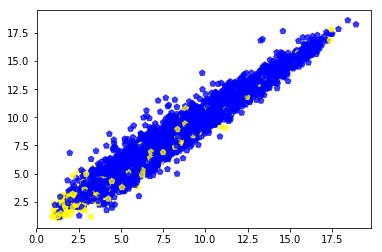

In [26]:
colors = lambda x: "Yellow" if x==1 else "Blue"
f = np.vectorize(colors)
fig = plt.figure()
plt.scatter(X_data.iloc[:,0], X_data.iloc[:,100], c=f(y_label), alpha=0.75, marker='p')
plt.show()
fig.savefig("dataset.eps")

### NOW we have 2 more X sets without any NaN values in them

In [15]:
### AN ARRAY SAVING ALL THE AVERAGES OF THE RUN MODELS ON THE TEST SET
avg_test_set = []
# Sequence of execution will be: xgboost, RF, Adaboost, KNN, svm

In [41]:
avg_train_set = []

### OUR FIRST MODEL IS XGBOOST:
#### We have used all three types of booster
see [this](https://xgboost.readthedocs.io/en/latest/parameter.html#parameters-for-tree-booster) for **report**

In [28]:
boosters = ['gbtree', 'gblinear', 'dart']
class_labels = ['Unknown gene', 'Cancer gene']
accXGBtrain = []
accXGBtest = []

for booster in boosters:
    xgb_model = xgb.XGBClassifier(max_depth=10, learning_rate=0.1, subsample=0.3, booster=booster, max_delta_step=6)
    xgb_model.fit(X_train, y_train)
    accTrain = xgb_model.score(X_train, y_train)
    accXGBtrain.append(accTrain)
    accTest = xgb_model.score(X_test, y_test)
    accXGBtest.append(accTest)
    print ("Accuracy on Train set: %f, Accuracy on Test set: %f\n"%(accTrain, accTest))
    
    pred = xgb_model.predict(X_test)
    print (classification_report(y_true=y_test, y_pred=pred, target_names=class_labels))

Accuracy on Train set: 0.979760, Accuracy on Test set: 0.961259

              precision    recall  f1-score   support

Unknown gene       0.96      1.00      0.98      6054
 Cancer gene       0.84      0.11      0.20       270

   micro avg       0.96      0.96      0.96      6324
   macro avg       0.90      0.56      0.59      6324
weighted avg       0.96      0.96      0.95      6324

Accuracy on Train set: 0.954881, Accuracy on Test set: 0.957306

              precision    recall  f1-score   support

Unknown gene       0.96      1.00      0.98      6054
 Cancer gene       0.00      0.00      0.00       270

   micro avg       0.96      0.96      0.96      6324
   macro avg       0.48      0.50      0.49      6324
weighted avg       0.92      0.96      0.94      6324



C:\Users\user\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy on Train set: 0.978916, Accuracy on Test set: 0.961259

              precision    recall  f1-score   support

Unknown gene       0.96      1.00      0.98      6054
 Cancer gene       0.80      0.12      0.21       270

   micro avg       0.96      0.96      0.96      6324
   macro avg       0.88      0.56      0.60      6324
weighted avg       0.96      0.96      0.95      6324



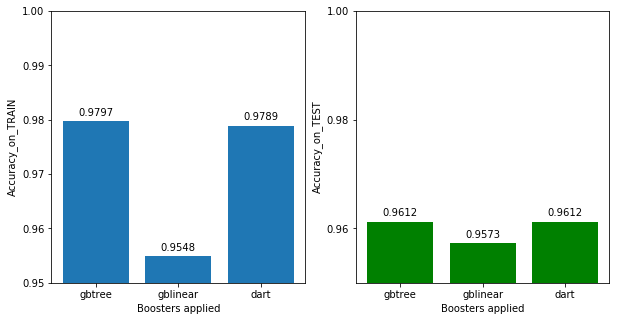

In [29]:
fig, axes = plt.subplots(1,2, figsize=(10,5))

axes[0].bar(boosters, accXGBtrain)
plt.locator_params(axis='y', nbins=5)
axes[0].set_ylim(0.95,1)
axes[0].set_ylabel("Accuracy_on_TRAIN")
axes[0].set_xlabel("Boosters applied")
labeltrain = []
for i in accXGBtrain:
    labeltrain.append(str(i)[:6])
for i in range(len(boosters)):
    axes[0].text(x = boosters[i] , y = accXGBtrain[i]+0.001, s = labeltrain[i], size = 10, ha='center')
    
axes[1].bar(boosters, accXGBtest, color='green')
plt.locator_params(axis='y', nbins=5)
axes[1].set_ylim(0.95,1)
axes[1].set_ylabel("Accuracy_on_TEST")
axes[1].set_xlabel("Boosters applied")
labeltest = []
for i in accXGBtest:
    labeltest.append(str(i)[:6])
for i in range(len(boosters)):
    axes[1].text(x = boosters[i] , y = accXGBtest[i]+0.001, s = labeltest[i], size = 10, ha='center')
    
plt.show()
fig.savefig('xgboost.eps', bbox_inches='tight')

In [30]:
avg_test_set.append(mean(accXGBtest))

### OUR SECOND MODEL: RANDOM FOREST
see [this](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) for report and [this](https://scikit-learn.org/stable/modules/ensemble.html#forest) 

FOR MANY POINTS OF Random Forest, in report [this](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/drf.html#faq)

Accuracies for n_trees = 100 and depth_tree = 6 are
Train: 0.963736 Test: 0.960942


Accuracies for n_trees = 100 and depth_tree = 8 are
Train: 0.964369 Test: 0.960942


Accuracies for n_trees = 100 and depth_tree = 10 are
Train: 0.965106 Test: 0.961101




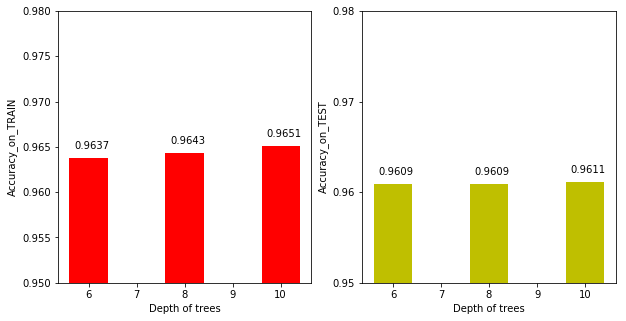

Accuracies for n_trees = 200 and depth_tree = 6 are
Train: 0.963841 Test: 0.960784


Accuracies for n_trees = 200 and depth_tree = 8 are
Train: 0.964685 Test: 0.960784


Accuracies for n_trees = 200 and depth_tree = 10 are
Train: 0.965106 Test: 0.961101




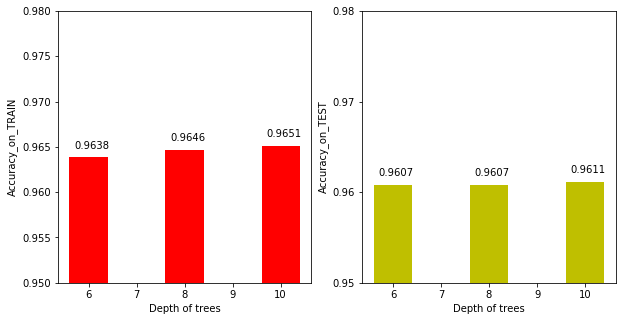

In [31]:
n_trees = [i for i in range(100,300,100)]
depth_trees = [i for i in range(6,11,2)]

accRFtest = []

for i in n_trees:
    accRFtrain = []
    accRFtest2 = []
    for j in depth_trees:
        rfc = RandomForestClassifier(n_estimators=i, max_depth=j, max_features=X_data.shape[1], oob_score=True, random_state=50)
        rfc.fit(X_train_woNan, y_train)
        acc_train = rfc.score(X_train_woNan, y_train)
        acc_test = rfc.score(X_test_woNan, y_test)
        print ("Accuracies for n_trees = %d and depth_tree = %d are\nTrain: %f Test: %f\n\n"%(i,j,acc_train,acc_test))
        accRFtrain.append(acc_train)
        accRFtest2.append(acc_test)
        accRFtest.append(acc_test)
    
    fig, axes = plt.subplots(1,2, figsize=(10,5))
    plt.locator_params(axis='y', nbins=5)

    axes[0].bar(depth_trees, accRFtrain, color='red')
    axes[0].set_ylim(0.95,0.98)
    axes[0].set_ylabel("Accuracy_on_TRAIN")
    axes[0].set_xlabel("Depth of trees")

    labeltrain = []
    for k in accRFtrain:
        labeltrain.append(str(k)[:6])
    for k in range(len(depth_trees)):
        axes[0].text(x = depth_trees[k]-0.3 , y = accRFtrain[k]+0.001, s = labeltrain[k], size = 10)

    axes[1].bar(depth_trees, accRFtest2, color='y')
    plt.locator_params(axis='y', nbins=5)
    axes[1].set_ylim(0.95,0.98)
    axes[1].set_ylabel("Accuracy_on_TEST")
    axes[1].set_xlabel("Depth of trees")

    labeltest = []
    for l in accRFtest2:
        labeltest.append(str(l)[:6])
    for l in range(len(depth_trees)):
        axes[1].text(x = depth_trees[l]-0.3 , y = accRFtest2[l]+0.001, s = labeltest[l], size = 10)
    plt.show()
    name = str(i) + "RF.eps"
    fig.savefig(name, bbox_inches='tight')

In [32]:
avg_test_set.append(mean(accRFtest))

### OUR THIRD MODEL: ADABOOST
see [this](https://scikit-learn.org/stable/modules/ensemble.html#adaboost) for report

Accuracy on train: 0.960468, Accuracy on test: 0.957622

Accuracy on train: 0.961101, Accuracy on test: 0.959203

Accuracy on train: 0.963631, Accuracy on test: 0.959203

Accuracy on train: 0.964685, Accuracy on test: 0.958729

Accuracy on train: 0.966266, Accuracy on test: 0.958571



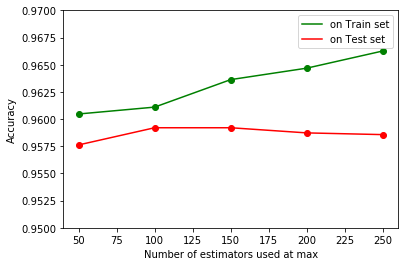

In [33]:
n_estimators = [i for i in range(50, 260, 50)]
accADAtrain = []
accADAtest = []
for n in n_estimators:
    ada = AdaBoostClassifier(n_estimators=n, random_state=50)
    ada.fit(X_train_woNan, y_train)
    acctr = ada.score(X_train_woNan, y_train)
    accte = ada.score(X_test_woNan, y_test)
    accADAtrain.append(acctr)
    accADAtest.append(accte)
    print ("Accuracy on train: %f, Accuracy on test: %f\n"%(acctr, accte))

fig = plt.figure()
plt.axis([40,260,0.95,0.97])
x_axis = np.linspace(50,250,5)
plt.xlabel("Number of estimators used at max")
plt.ylabel("Accuracy")
plt.scatter(n_estimators, accADAtrain, color='green')
plt.plot(x_axis, accADAtrain, color='green', label="on Train set")
plt.scatter(n_estimators, accADAtest, color='red')
plt.plot(x_axis, accADAtest, color='red', label="on Test set")
plt.legend()
plt.show()
fig.savefig("adaboost.eps", bbox_inches='tight')

In [34]:
avg_test_set.append(mean(accADAtest))

### OUR FOURTH MODEL: KNN

In [35]:
k_range = [i for i in range(2,21,2)]
print(k_range)
accKNNtrain = []
accKNNtest = []

for i in k_range:
    new_knn = KNeighborsClassifier(n_neighbors=i)
    new_knn.fit(X_train_woNan, y_train)
    accuracy_tr_knn = new_knn.score(X_train_woNan, y_train)
    accuracy_te_knn = new_knn.score(X_test_woNan, y_test)
    print ("for neighbors = %d, accuracy_train is %f accuracy_test is :%f"%(i,accuracy_tr_knn,accuracy_te_knn))
    accKNNtrain.append(accuracy_tr_knn)
    accKNNtest.append(accuracy_te_knn)

[2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
for neighbors = 2, accuracy_train is 0.961838 accuracy_test is :0.957464
for neighbors = 4, accuracy_train is 0.957833 accuracy_test is :0.958254
for neighbors = 6, accuracy_train is 0.956568 accuracy_test is :0.958571
for neighbors = 8, accuracy_train is 0.955830 accuracy_test is :0.957780
for neighbors = 10, accuracy_train is 0.955197 accuracy_test is :0.957306
for neighbors = 12, accuracy_train is 0.954565 accuracy_test is :0.957306
for neighbors = 14, accuracy_train is 0.954354 accuracy_test is :0.957306
for neighbors = 16, accuracy_train is 0.954143 accuracy_test is :0.957147
for neighbors = 18, accuracy_train is 0.953827 accuracy_test is :0.956831
for neighbors = 20, accuracy_train is 0.953405 accuracy_test is :0.956673


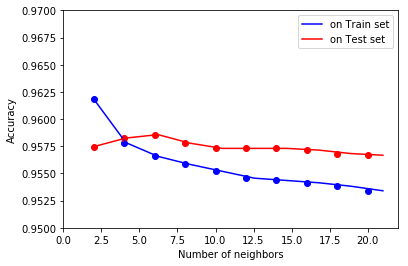

In [36]:
fig = plt.figure()
plt.axis([0,22,0.95,0.97])
x_axis = np.linspace(2,21,10)
plt.xlabel("Number of neighbors")
plt.ylabel("Accuracy")
plt.scatter(k_range, accKNNtrain, color='blue')
plt.plot(x_axis, accKNNtrain, color='blue', label="on Train set")
plt.scatter(k_range, accKNNtest, color='red')
plt.plot(x_axis, accKNNtest, color='red', label="on Test set")
plt.legend()
plt.show()
fig.savefig("knn.eps", bbox_inches='tight')

In [37]:
avg_test_set.append(mean(accKNNtest))

### OUR LAST MODEL: SVM

for SVC see [this](https://scikit-learn.org/stable/modules/svm.html)
for gridSearch see [this](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

In [19]:
accSVMtest = []
accSVMtrain = []
#accSVMtests2 = []
c_values = [i/10 for i in range(1,20,2)]

for i in c_values:
    lsvm = SVC(gamma='auto', C=i, random_state=50)
    lsvm.fit(X_train_woNan, y_train)
    train_sc = lsvm.score(X_train_woNan, y_train)
    test_sc = lsvm.score(X_test_woNan, y_test)
    accSVMtest.append(test_sc)
    accSVMtrain.append(train_sc)
    print ("(for C=%f) Acc on train: %f on test: %f\n"%(i, train_sc, test_sc))

(for C=0.100000) Acc on train: 0.954881 on test: 0.957306

(for C=0.300000) Acc on train: 0.956040 on test: 0.957306

(for C=0.500000) Acc on train: 0.956357 on test: 0.957306

(for C=0.700000) Acc on train: 0.956357 on test: 0.957306

(for C=0.900000) Acc on train: 0.956884 on test: 0.957306

(for C=1.100000) Acc on train: 1.000000 on test: 0.957306

(for C=1.300000) Acc on train: 1.000000 on test: 0.957306

(for C=1.500000) Acc on train: 1.000000 on test: 0.957306

(for C=1.700000) Acc on train: 1.000000 on test: 0.957306

(for C=1.900000) Acc on train: 1.000000 on test: 0.957306



In [3]:
fig = plt.figure()
plt.axis([0.05,1.95,0.95,1])
x_axis = np.linspace(0,2,10)
plt.xlabel("Variation of hyperparameter C")
plt.ylabel("Accuracy")
plt.scatter(c_values, accSVMtrain, color='blue')
plt.plot(x_axis, accSVMtrain, color='blue', label="on Train set")
plt.scatter(c_values, accSVMtest, color='y')
plt.plot(x_axis, accSVMtest, color='y', label="on Test set")
plt.legend()
plt.show()
fig.savefig("svm.eps", bbox_inches='tight')

NameError: name 'c_values' is not defined

In [39]:
avg_test_set.append(mean(accSVMtest))
avg_test_set

[0.9599409656335652,
 0.9609424414927261,
 0.9586654016445288,
 0.9574636306135358,
 0.9573055028462998,
 0.9573055028462998]

In [40]:
avg_test_set=avg_test_set[:-1]
avg_test_set

[0.9599409656335652,
 0.9609424414927261,
 0.9586654016445288,
 0.9574636306135358,
 0.9573055028462998]

In [42]:
avg_train_set.append(mean(accXGBtrain))
avg_train_set.append(mean(accRFtrain))
avg_train_set.append(mean(accADAtrain))
avg_train_set.append(mean(accKNNtrain))
avg_train_set.append(mean(accSVMtrain))
avg_train_set

[0.9711856068592312,
 0.9645442406353222,
 0.9632300231920725,
 0.9557558507273878,
 0.9780518659076534]

In [49]:
avg_train_set, avg_test_set

([0.9711856068592312,
  0.9645442406353222,
  0.9632300231920725,
  0.9557558507273878,
  0.9780518659076534],
 [0.9599409656335652,
  0.9609424414927261,
  0.9586654016445288,
  0.9574636306135358,
  0.9573055028462998])